# Introduction to OTC wallet analysis

## Queries for obtaining Dataset and pre-process

In first place, after the task was given, my first thought was to query txns on ETH blockchain with OTC behaviors but after a couple of queries with no results to display, in my research process I found this [Chainalysis](https://www.chainalysis.com/blog/organized-crime-crypto/) article, where based on its graph visualizations I was able to identify Tron as a better source for such kind of txns or behaviors, then I switched my focus to Tron Network, and wrote [this](https://dune.com/queries/5241136/8613964/) Dune query.

 The query identifies potential OTC transactions by focusing on high-value TRX (expressed in sun) transactions and USDT transfers, filtering for suspicious activity patterns (low transaction counts, new addresses, or round-number values). The results provide detailed transaction data, address activity metrics, and risk profiles, needed for this next part of my analysis. These are the parameters considered in the query for obtaining the dataset used in this Jupyter NB.

   ### Key Parameters

- **Time Frame**: Last 30 days (`block_time >= CURRENT_DATE - INTERVAL '30' DAY`).
- **Transaction Filters**:
  - Successful transactions '(`success = true`) with value > 0'.
  - High-value threshold: '≥100M TRX (`value >= 100000000000`)'.
- **USDT Transfer Filters**:
  - Transfer event signature '(`topic0 = 0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef`)'.
  - USDT contract addresses: Specific addresses or names containing `usdt`/`tether`.
- **Address Activity Filters**:
  - Low activity: ≤6 transactions '(`tx_count <= 6`)'.
  - New addresses: Sender '(`first_tx_time >= CURRENT_DATE - INTERVAL '30' DAY`), Receiver (`first_tx_time >= CURRENT_DATE - INTERVAL '60' DAY`)'.
  - OTC pattern: 2–10 transactions with ≤3 active days.
- **OTC Indicators**: Round-number values '(`MOD(t.value, 1000000000) = 0`)'.
- **Output**: Up to 1,000 transactions, ordered by `block_time DESC`, `value DESC`. 

The dataset obtained is stored as 'possible_OTC_wallets.csv' 

Then I cleaned the dataset to show add 'transaction_value_in_TRX' column by dividing the 'transaction_value' column by 1000000, for transforming the number from sun, the lowest unit in TRX to TRX readable amounts. 

The second dataset is stored as 'possible_OTC_wallets_cleaned_v1.csv'. 

In the process of cleaning the data I encountered that the 'transaction_hash', 'sender' and 'receiver' columns are hexadecimal _ETH-like_ addresses, and for the purpose of cross-check those addresses in its correct Tron format in platforms like _Arkham_ or _tronscan_ it was needed to encode such addresses to base58check for correct format. then I wrote the function in the next cell.

In [59]:
import hashlib
import base58
import pandas as pd

def eth_to_tron_address(eth_address):
    try:
        # Validate Ethereum address format
        if not isinstance(eth_address, str) or len(eth_address) != 42 or not eth_address.startswith('0x'):
            return 'Invalid Address'
        
        # Remove '0x' and decode hex to bytes
        eth_address = eth_address.lower().replace('0x', '')
        address_bytes = bytes.fromhex(eth_address)
        
        # Add Tron prefix (0x41)
        tron_prefix = b'\x41'
        prefixed_address = tron_prefix + address_bytes
        
        # Compute double SHA-256 hash
        first_hash = hashlib.sha256(prefixed_address).digest()
        second_hash = hashlib.sha256(first_hash).digest()
        
        # Take first 4 bytes of second hash as checksum
        checksum = second_hash[:4]
        
        # Combine prefixed address and checksum
        final_bytes = prefixed_address + checksum
        
        # Encode to Base58Check
        tron_address = base58.b58encode(final_bytes).decode('utf-8')
        
        return tron_address
    except Exception as e:
        return f"Error: {str(e)}"

# Example: Convert a single address
eth_address = '0x27e0ce6fdf815c33f68fb2593e29844d84da5757'
tron_address = eth_to_tron_address(eth_address)
print(f"Ethereum Address: {eth_address}")
print(f"Tron Address: {tron_address}")

# Load and process CSV
try:
    df = pd.read_csv('/home/tripl3tr3s/projects/otc_wallet_analysis/data/possible_OTC_wallets_cleaned_v1.csv')
    
    # Apply conversion to sender and receiver columns
    df['sender_tron_address'] = df['sender'].apply(eth_to_tron_address)
    df['receiver_tron_address'] = df['receiver'].apply(eth_to_tron_address)
    
    # Save the updated DataFrame
    df.to_csv('possible_OTC_wallets_with_tron_addresses.csv', index=False)
    
    # Display the first few rows
    print(df[['sender', 'sender_tron_address', 'receiver', 'receiver_tron_address']].head())
except FileNotFoundError:
    print("Error: 'possible_OTC_wallets.csv' not found. Please check the file path.")
except Exception as e:
    print(f"Error processing CSV: {str(e)}")

Ethereum Address: 0x27e0ce6fdf815c33f68fb2593e29844d84da5757
Tron Address: TDc4fMykFxrimwwTeNm7YXjoorHqXLGcLs
                                       sender  \
0  0x27e0ce6fdf815c33f68fb2593e29844d84da5757   
1  0xd3910012a66288289c6bc2e758da9e876b3cf993   
2  0x569ca0fd77d36609543b8975807401e582c6460e   
3  0xc314bdf9650eba09b4f2b2715f7e011276ad38de   
4  0xb15dc2a8271b323fcf4464b328485fd3bb7533e2   

                  sender_tron_address  \
0  TDc4fMykFxrimwwTeNm7YXjoorHqXLGcLs   
1  TVFsHLBoPnHnb32gQHJuKw5RqziGxuoyJW   
2  THsAkKZr11KrxzujcFx4mH1R97SDLLnp7n   
3  TTkhcejW39VdDmxgv9DxDJSboAZN4NhD1d   
4  TS92vbereckRSP9hHPCvzfibuj4HG3X2Ys   

                                     receiver  \
0  0x99469fd5aa08cfe836395ce993c0ebd567e2c14f   
1  0x2a68baf67f1c497d9a4a609276a90dcd6ea77444   
2  0xd3910012a66288289c6bc2e758da9e876b3cf993   
3  0x2dfabe28cf3a6c4b4c7a6bbe4217d949ec3df04c   
4  0xc686c48436aec3a1dfce4ac5a4526c39366985ba   

                receiver_tron_address  
0  TPwezUWpEG

### Result

The obtained dataset is stored as `possible_OTC_wallets_with_tron_addresses.csv` which is used from this point and onwards, on the next parts of the cleaning process where I transformed `block_time` column to `datetime` and printed the database info and the head for quick scoping. 



In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

# Load the CSV file with Tron addresses
try:
    df = pd.read_csv('/home/tripl3tr3s/projects/otc_wallet_analysis/data/possible_OTC_wallets_with_tron_addresses.csv')
except FileNotFoundError:
    df = pd.read_csv('/home/tripl3tr3s/projects/otc_wallet_analysis/data/possible_OTC_wallets_cleaned_v1.csv')
    print("Loaded original CSV. Tron addresses not found; rerun address conversion if needed.")

# Convert block_time to datetime
df['block_time'] = pd.to_datetime(df['block_time'], format='%d/%m/%Y %H:%M')

# Display basic info
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_hash          1000 non-null   object        
 1   block_time                1000 non-null   datetime64[ns]
 2   block_number              1000 non-null   int64         
 3   sender                    1000 non-null   object        
 4   receiver                  990 non-null    object        
 5   transaction_value_in_TRX  1000 non-null   float64       
 6   sender_tx_count           1000 non-null   int64         
 7   sender_first_tx           1000 non-null   object        
 8   sender_active_days        1000 non-null   int64         
 9   receiver_tx_count         990 non-null    float64       
 10  receiver_first_tx         990 non-null    object        
 11  receiver_active_days      990 non-null    float64       
 12  contrac

## Filtering out even more.

The next step was filter for txns over 400,000 TRX, ~$110k USD at current TRX price. 
And plotting a simple distribution of txns valued equal or above 400,000 TRX.

Number of transactions >= 400000 TRX: 428

Top 5 high-value transactions:
                                     transaction_hash  \
7   0x26307e9e90a8aa87a4b8065915bb357e13512f246020...   
29  0x8e93d214333889065fd33796c08dd00ec7ff90558cdc...   
30  0x2de190622af9f902d2f6f296d23aac6f27d91765b44c...   
31  0x4418f58fe8d678f32c94302bf704d3c3fc9535185c4d...   
32  0xc5702b836ab227af9a6e62befde10fa4acd5de0b5350...   

                   sender_tron_address               receiver_tron_address  \
7   TTvMe55USCAPy2M1FZjw8DLMuZLbuSZyLE  TMbRMNrFfAD18Hekpp5sXrmsZ6rnS529TY   
29  TJYbE9mz5tRYo6gng6okCSe2MHi77yKfBq  TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf   
30  TAGrk65jKnQMY6uxJt4PrvhamRBCUcFMjh  TJYbE9mz5tRYo6gng6okCSe2MHi77yKfBq   
31  TK86Qm97uM848dMk8G7xNbJB7zG1uW3h1n  TFTWNgDBkQ5wQoP8RXpRznnHvAVV8x5jLu   
32  TVoNsDjduEnDBU3Q2dn56xa168x7PnFAWZ  TAGrk65jKnQMY6uxJt4PrvhamRBCUcFMjh   

    transaction_value_in_TRX contract_name  
7                   410000.0           NaN  
29                  4699

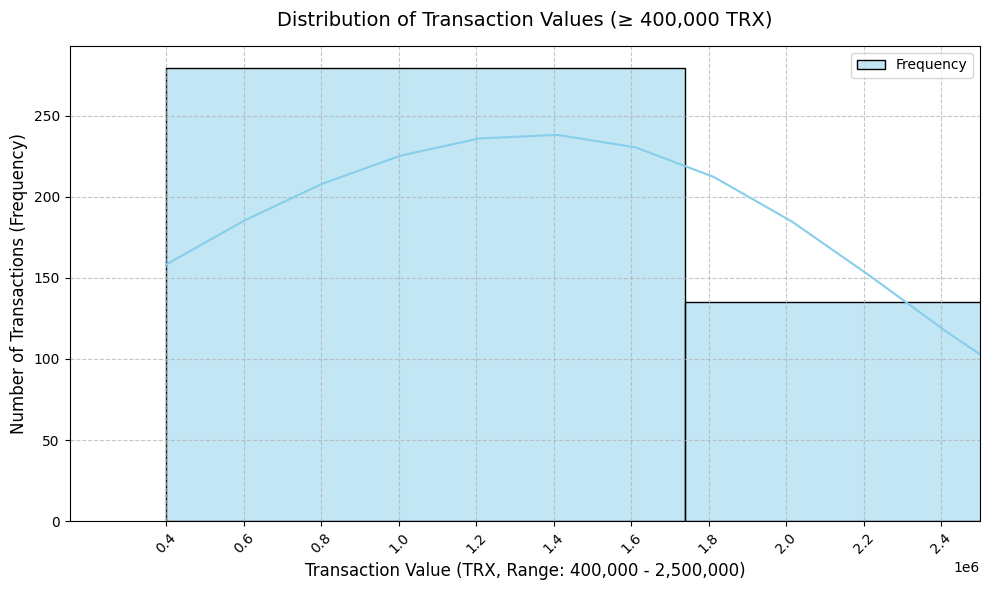

In [ ]:
# Make sure cell 1 has been run so that 'df' is defined

# Define threshold for high-value transactions
value_threshold = 400000 # ~$110,000 USD at current TRX price

# Filter high-value transactions
high_value_df = df[df['transaction_value_in_TRX'] >= value_threshold]

# Display summary
print(f"Number of transactions >= {value_threshold} TRX: {len(high_value_df)}")
print("\nTop 5 high-value transactions:")
print(high_value_df[['transaction_hash', 'sender_tron_address', 'receiver_tron_address', 'transaction_value_in_TRX', 'contract_name']].head())

# Plot distribution of high-value transactions with enhanced visualization
plt.figure(figsize=(10, 6))  # tweak figure size for better readability
sns.histplot(data=high_value_df, x='transaction_value_in_TRX', bins=30, kde=True, color='skyblue', label='Frequency')
plt.title('Distribution of Transaction Values (≥ 400,000 TRX)', fontsize=14, pad=15)
plt.xlabel('Transaction Value (TRX, Range: 400,000 - 2,500,000)', fontsize=12)
plt.ylabel('Number of Transactions (Frequency)', fontsize=12)
plt.xlim(150000, 2500000)  # Set x-axis range to match data distribution
plt.xticks(np.arange(400000, 2600000, 200000), rotation=45)  # Custom x-ticks for clarity
plt.grid(True, linestyle='--', alpha=0.7)  # Add grid lines
plt.legend()  # Add legend for KDE
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

### Analysis and Visualization of Potential OTC Wallets

This code cell processes the transaction dataset to identify and visualize potential Over-the-Counter (OTC) wallets based on low activity patterns. It flags wallets with low transaction counts (≤10) or short active periods (≤5 days) for senders and receivers, creating a `potential_otc_wallet` flag when either condition is met. The cell prints the count of transactions involving potential OTC wallets and a sample of relevant data (sender/receiver addresses, transaction value, and activity metrics). 

It then generates a scatter plot to visualize the relationship between sender and receiver transaction counts for potential OTC transactions. The plot uses:
- **X-axis**: Sender transaction count (log scale).
- **Y-axis**: Receiver transaction count (log scale).
- **Color and Size**: Transaction value in TRX, with a `viridis` palette and size range (20–200) for emphasis.
- **Purpose**: To highlight transactions with low activity patterns, which may indicate OTC trading, with logarithmic scales to handle skewed data and transparency/gridlines for clarity.

Number of transactions involving potential OTC wallets: 877

Sample of potential OTC transactions:
                  sender_tron_address               receiver_tron_address  \
0  TDc4fMykFxrimwwTeNm7YXjoorHqXLGcLs  TPwezUWpEGmFBENNWJHwXHRG1D2NCEEt5s   
1  TVFsHLBoPnHnb32gQHJuKw5RqziGxuoyJW  TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf   
2  THsAkKZr11KrxzujcFx4mH1R97SDLLnp7n  TVFsHLBoPnHnb32gQHJuKw5RqziGxuoyJW   
3  TTkhcejW39VdDmxgv9DxDJSboAZN4NhD1d  TEAKncB31q3NjrJ7pbsKW4pC84sUCuPS7w   
4  TS92vbereckRSP9hHPCvzfibuj4HG3X2Ys  TU4vEruvZwLLkSfV9bNw12EJTPvNr7Pvaa   

   transaction_value_in_TRX  sender_tx_count  receiver_tx_count  \
0                  123000.0                1                  5   
1                  394994.0                2                 17   
2                  394994.0                1                  2   
3                  250000.0                2                  2   
4                  129957.0                2                  5   

   sender_active_days  receiver_act

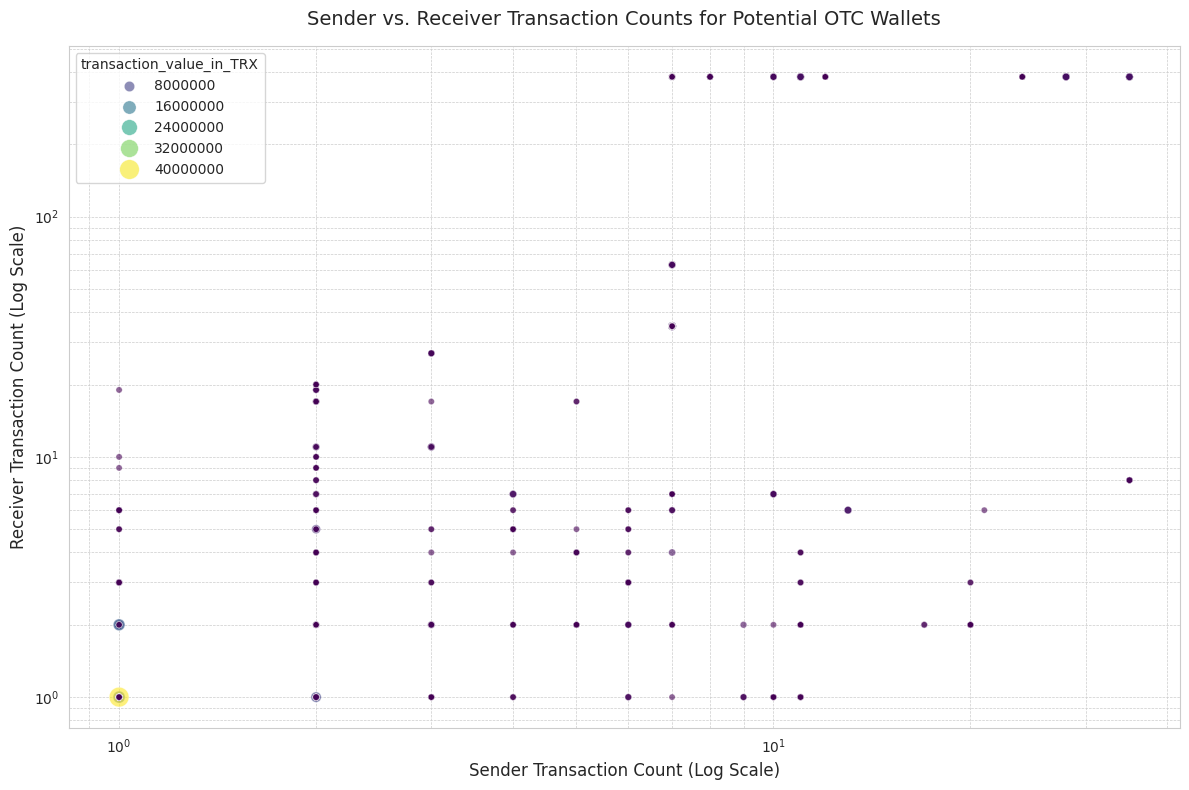

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define thresholds for low activity
tx_count_threshold = 10  # Low transaction count
active_days_threshold = 5  # Short active period

# Flag low-activity senders and receivers
df['sender_low_activity'] = (df['sender_tx_count'] <= tx_count_threshold) | (df['sender_active_days'] <= active_days_threshold)
df['receiver_low_activity'] = (df['receiver_tx_count'] <= tx_count_threshold) | (df['receiver_active_days'] <= active_days_threshold)

# Create a flag for potential OTC wallets (either sender or receiver is low activity)
df['potential_otc_wallet'] = df['sender_low_activity'] | df['receiver_low_activity']

# Summarize
print("Number of transactions involving potential OTC wallets:", df['potential_otc_wallet'].sum())
print("\nSample of potential OTC transactions:")
print(df[df['potential_otc_wallet']][['sender_tron_address', 'receiver_tron_address', 'transaction_value_in_TRX', 'sender_tx_count', 'receiver_tx_count', 'sender_active_days', 'receiver_active_days']].head())

# Plot transaction counts for potential OTC wallets with enhancements
plt.figure(figsize=(12, 8))  # Larger figure size for better readability
sns.scatterplot(data=df[df['potential_otc_wallet']], 
                x='sender_tx_count', 
                y='receiver_tx_count', 
                hue='transaction_value_in_TRX', 
                size='transaction_value_in_TRX', 
                palette='viridis',  # Distinct color palette
                sizes=(20, 200),    # Wider size range for visibility
                alpha=0.6,          # Transparency to handle overplotting
                legend='brief')     # Brief legend to avoid clutter

# Apply logarithmic scale to both axes
plt.xscale('log')
plt.yscale('log')

# Set titles and labels
plt.title('Sender vs. Receiver Transaction Counts for Potential OTC Wallets', fontsize=14, pad=15)
plt.xlabel('Sender Transaction Count (Log Scale)', fontsize=12)
plt.ylabel('Receiver Transaction Count (Log Scale)', fontsize=12)

# Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### Analysis of Reciprocal Wallet Pairs

This code cell identifies and analyzes reciprocal wallet pairs (sender-receiver pairs with multiple transactions) to detect potential OTC trading patterns. It first removes rows with missing sender or receiver addresses. Then, it creates a `wallet_pair` column by sorting sender and receiver addresses into tuples to ensure directionality does not affect pair identification. The data is grouped by `wallet_pair` to count transactions per pair, filtering for pairs with more than one transaction. The results are merged back with the original dataset to retain transaction details.

The cell prints:
- The number of wallet pairs with multiple transactions.
- The top 5 reciprocal pairs by transaction count.
- A sample of transactions for the top reciprocal pair, including sender/receiver addresses, transaction value in TRX, and block time.

**Purpose**: To highlight frequent interactions between wallet pairs, which may indicate OTC trading, by focusing on reciprocal transaction patterns.

In [94]:
# Drop rows with missing sender or receiver in place
df.dropna(subset=['sender', 'receiver'], inplace=True)

# Create a sorted tuple of sender-receiver pairs to avoid directionality issues
df['wallet_pair'] = df.apply(lambda x: tuple(sorted([x['sender_tron_address'], x['receiver_tron_address']])), axis=1)

# Group by wallet pair and count transactions
pair_counts = df.groupby('wallet_pair').size().reset_index(name='pair_tx_count')

# Filter pairs with multiple transactions
reciprocal_pairs = pair_counts[pair_counts['pair_tx_count'] > 1]

# Merge with original DataFrame to get details
reciprocal_df = df.merge(reciprocal_pairs, on='wallet_pair', how='inner')

# Summarize
print("Number of wallet pairs with multiple transactions:", len(reciprocal_pairs))
print("\nTop reciprocal pairs:")
print(reciprocal_pairs.sort_values('pair_tx_count', ascending=False).head())

# Display sample transactions for top reciprocal pair
top_pair = reciprocal_pairs.sort_values('pair_tx_count', ascending=False).iloc[0]['wallet_pair']
print(f"\nTransactions for top reciprocal pair {top_pair}:")
print(reciprocal_df[reciprocal_df['wallet_pair'] == top_pair][['sender_tron_address', 'receiver_tron_address', 'transaction_value_in_TRX', 'block_time']])

Number of wallet pairs with multiple transactions: 97

Top reciprocal pairs:
                                           wallet_pair  pair_tx_count
37   (TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi, TCFNp179L...             35
91   (TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj, TEdtftSTn...             28
97   (TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj, TLGXeWvAy...             28
76   (TBcRRYrjm5k9tJBREdaft2LgxRZtaaWjtV, TJ4NNy8xZ...             28
103  (TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj, TP5pFBezq...             28

Transactions for top reciprocal pair ('TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi', 'TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj'):
                    sender_tron_address               receiver_tron_address  \
553  TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   
554  TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   
555  TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   
556  TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi  TCFNp179Lg46D16zKoumd4Poa2WFFd

### Token Usage Analysis and Visualization

This code cell analyzes token usage in transactions by grouping the dataset by `contract_name` (USDT, Tether). It calculates:
- Transaction count, total value (in TRX), and average value per token.
- Number of unique senders and receivers per token.

The results are sorted by total transaction value in descending order and displayed as a summary table. A bar plot visualizes the total transaction value (in millions of TRX) for each token, with:
- **X-axis**: Token name (`contract_name`).
- **Y-axis**: Total transaction value (formatted in millions of TRX).
- **Features**: Color-coded bars (Set2 palette), data labels showing values in millions, rotated x-axis labels (60°), gridlines, and a logarithmic-friendly y-axis format.

**Purpose**: To identify the most significant tokens by transaction volume, highlighting their role in potential OTC trading on the Tron blockchain.

Token Usage Summary:
  contract_name  tx_count  total_value_trx  avg_value_trx  unique_senders  \
1       TrueUSD       161      147499900.0  916148.447205              58   
2          wbtc       161      147499900.0  916148.447205              58   
0    Tether_USD        69       65652884.0  951491.072464              48   

   unique_receivers  
1                 7  
2                 7  
0                 5  


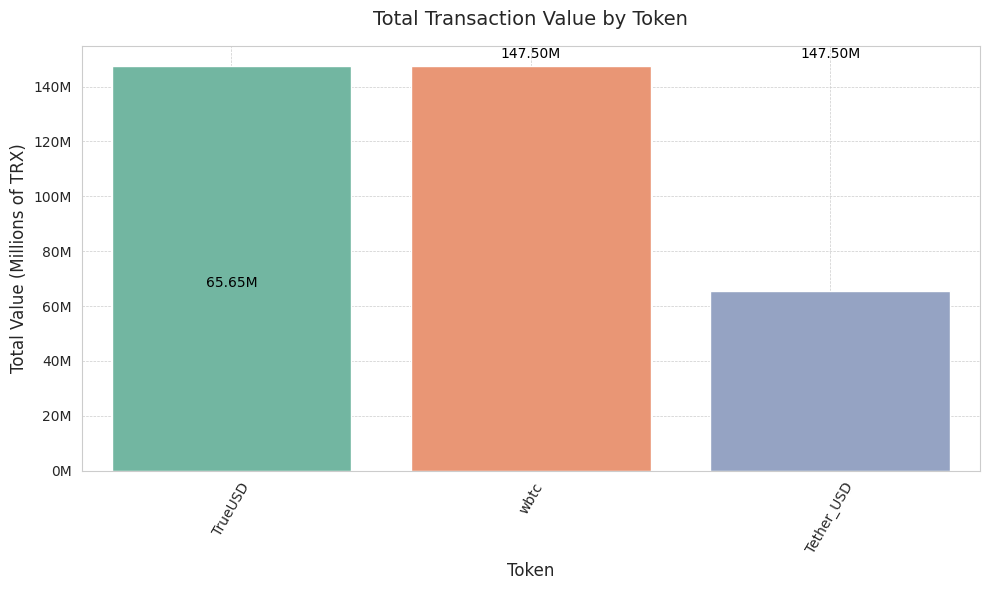

In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Group by contract_name and summarize transaction values
token_summary = df.groupby('contract_name').agg({
    'transaction_value_in_TRX': ['count', 'sum', 'mean'],
    'sender_tron_address': 'nunique',
    'receiver_tron_address': 'nunique'
}).reset_index()

# Flatten column names
token_summary.columns = ['contract_name', 'tx_count', 'total_value_trx', 'avg_value_trx', 'unique_senders', 'unique_receivers']

# Sort the DataFrame by total_value_trx in descending order
token_summary = token_summary.sort_values('total_value_trx', ascending=False)

# Display summary
print("Token Usage Summary:")
print(token_summary)

# Plot total transaction value by token with enhancements
plt.figure(figsize=(10, 6))

# Create bar plot with a color palette for visual distinction
sns.barplot(data=token_summary, x='contract_name', y='total_value_trx', palette='Set2')

# Add data labels on top of each bar
for index, row in token_summary.iterrows():
    plt.text(index, row['total_value_trx'] + 0.02 * row['total_value_trx'],  # Position slightly above the bar
             f'{row["total_value_trx"]/1e6:.2f}M',  # Display value in millions
             ha='center', fontsize=10, color='black')

# Set title and labels with improved styling
plt.title('Total Transaction Value by Token', fontsize=14, pad=15)
plt.xlabel('Token', fontsize=12)
plt.ylabel('Total Value (Millions of TRX)', fontsize=12)

# Rotate x-axis labels to 60 degrees for better readability
plt.xticks(rotation=60)

# Format y-axis to show millions of TRX
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Add gridlines for better estimation
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optimize layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

### Risk Profile Analysis and Visualization

This code cell analyzes transactions by sender and receiver risk profiles (Low Activity, New Address, Established). It groups the dataset by `sender_risk_profile` and `receiver_risk_profile`, calculating:
- Transaction count, total value (in TRX), and average value per profile pair.
- Number of unique senders and receivers per pair.

The results are sorted by total transaction value and displayed as a summary table. A heatmap visualizes the transaction count for each sender-receiver risk profile pair, with:
- **X-axis**: Receiver risk profile.
- **Y-axis**: Sender risk profile.
- **Color**: Transaction count (Blues cmap, 0–700 scale).
- **Features**: Cell borders, dynamic annotation colors (white for counts >300, black otherwise), and formatted annotations for clarity.

**Purpose**: To identify patterns in transaction activity across risk profile combinations, highlighting potential OTC trading risks.

Risk Profile Summary:
          sender_risk_profile       receiver_risk_profile  tx_count  \
3  low_risk_moderate_activity      low_risk_high_activity       163   
7    medium_risk_low_activity      low_risk_high_activity       219   
0               high_risk_new               high_risk_new       248   
8    medium_risk_low_activity  low_risk_moderate_activity       105   
2               high_risk_new    medium_risk_low_activity        74   
6    medium_risk_low_activity               high_risk_new        69   
4  low_risk_moderate_activity  low_risk_moderate_activity        55   
9    medium_risk_low_activity    medium_risk_low_activity        21   
1               high_risk_new  low_risk_moderate_activity        27   
5  low_risk_moderate_activity    medium_risk_low_activity         9   

   total_value_trx  avg_value_trx  unique_senders  unique_receivers  
3      189640240.0   1.163437e+06               6                 1  
7      180214004.0   8.228950e+05              26       

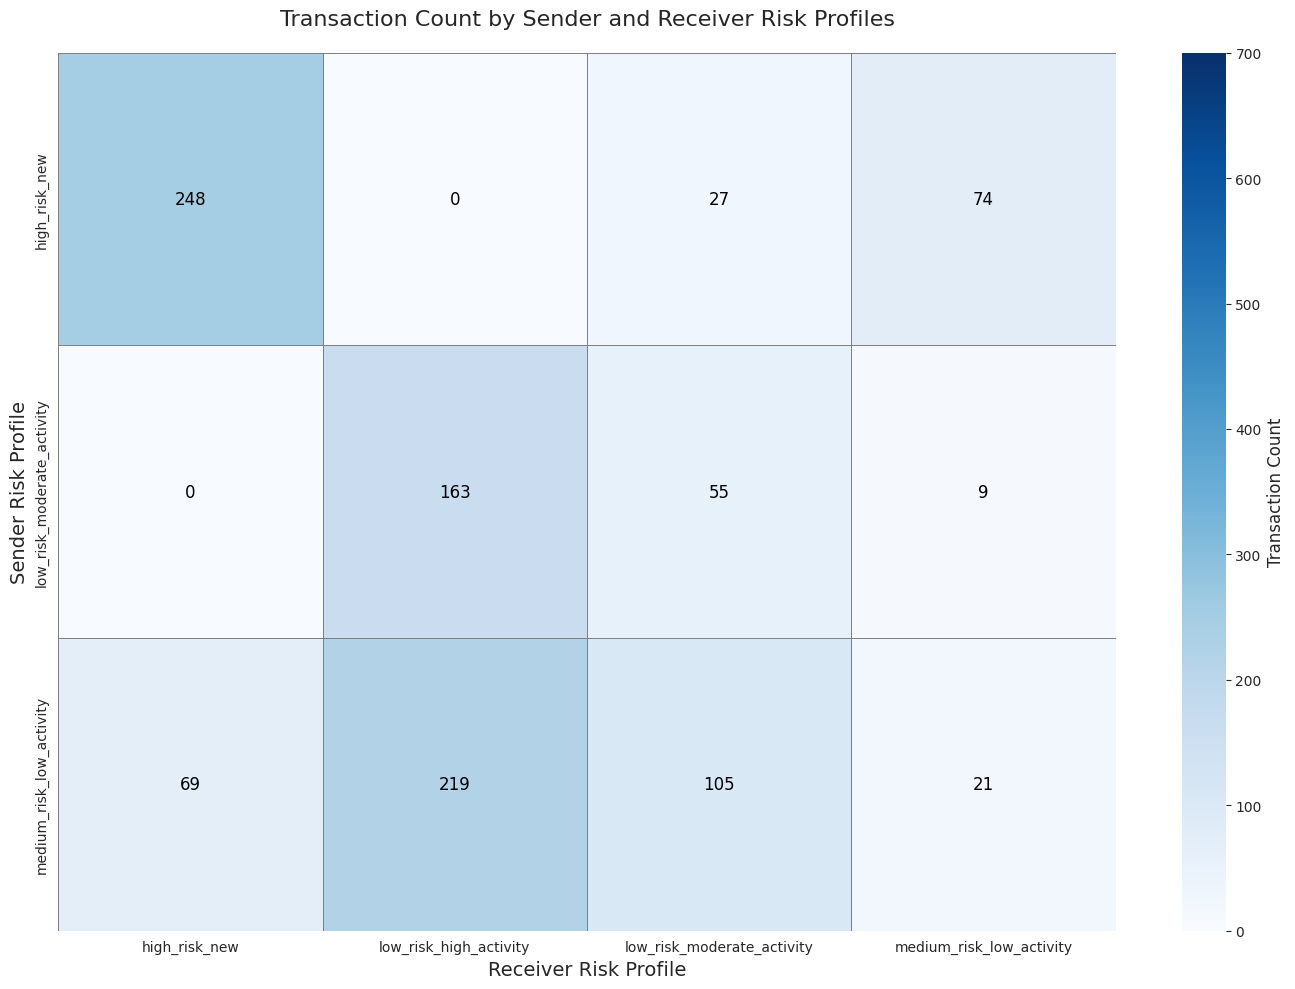

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize risk profiles
risk_profile_summary = df.groupby(['sender_risk_profile', 'receiver_risk_profile']).agg({
    'transaction_value_in_TRX': ['count', 'sum', 'mean'],
    'sender_tron_address': 'nunique',
    'receiver_tron_address': 'nunique'
}).reset_index()

# Flatten column names
risk_profile_summary.columns = ['sender_risk_profile', 'receiver_risk_profile', 'tx_count', 'total_value_trx', 'avg_value_trx', 'unique_senders', 'unique_receivers']

# Display summary
print("Risk Profile Summary:")
print(risk_profile_summary.sort_values('total_value_trx', ascending=False))

# Plot transaction count by risk profile pair with enhancements
plt.figure(figsize=(14, 10))  # Larger figure size for better visibility

# Create pivot table
pivot_table = risk_profile_summary.pivot_table(values='tx_count', index='sender_risk_profile', columns='receiver_risk_profile', fill_value=0)

# Create heatmap with adjusted color scale, borders, and dynamic annotation colors
ax = sns.heatmap(pivot_table, 
                 annot=True, 
                 fmt='.0f', 
                 cmap='Blues', 
                 vmin=0, 
                 vmax=700,  # Set to slightly above the maximum value (699)
                 linewidths=0.5, 
                 linecolor='gray',  # Add cell borders
                 annot_kws={"size": 12})  # Increase annotation font size

# Dynamically adjust annotation colors based on cell value
for text in ax.texts:
    text_val = float(text.get_text())
    if text_val > 300:  # Threshold for switching to white text
        text.set_color('white')
    else:
        text.set_color('black')

# Set title and labels with larger font sizes
plt.title('Transaction Count by Sender and Receiver Risk Profiles', fontsize=16, pad=20)
plt.xlabel('Receiver Risk Profile', fontsize=14)
plt.ylabel('Sender Risk Profile', fontsize=14)

# Adjust color bar
cbar = ax.collections[0].colorbar
cbar.set_label('Transaction Count', fontsize=12)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()

### Transaction Network Analysis and Visualization

This code cell constructs and analyzes a directed graph of transactions using NetworkX to identify key wallets and their interactions, potentially indicating OTC trading patterns. It creates a graph where nodes are wallets and edges represent transactions, weighted by transaction value (in TRX). Centrality measures (degree, betweenness, closeness) and total transaction volume (inbound + outbound) are calculated for each wallet. The top 10 wallets by degree centrality are highlighted.

**Outputs**:
- **Summary**: Prints details for the top 10 wallets, including centrality scores, total volume, and connection counts (inbound/outbound).
- **Visualization** (3-panel figure):
  1. **Network Plot**: Displays a subgraph of top wallets and their immediate neighbors, with node colors (red/orange/gold for top ranks, blue shades for volume) and sizes based on volume, and edge widths/colors based on transaction value.
  2. **Degree Distribution Histogram**: Shows the distribution of node connections, with colors indicating high-degree hubs (red/orange) and a mean degree line.
  3. **Network Statistics**: Text panel summarizing metrics like total wallets, transactions, network density, clustering, diameter, and top wallet stats.
- **Transaction Flow Analysis**: Details inflow, outflow, and net flow for top wallets, labeling them as net senders, receivers, or balanced.
- **Network Health Indicators**: Reports hub concentration, transaction volume concentration, and connectivity.

**Purpose**: To visualize and quantify wallet interactions, identifying central hubs and transaction flow patterns that may suggest OTC trading activity on the Tron blockchain.

Top 10 wallets by centrality:
 1. TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj
    Degree Centrality: 0.0650 | Betweenness: 0.0000
    Total Volume: 26,498,692 TRX | Connections: 32 (In: 32, Out: 0)

 2. TXrauXw2wazRPZd2Q5tSYRnFveCyeaCign
    Degree Centrality: 0.0366 | Betweenness: 0.0108
    Total Volume: 3,711,299 TRX | Connections: 18 (In: 11, Out: 7)

 3. TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf
    Degree Centrality: 0.0325 | Betweenness: 0.0066
    Total Volume: 5,161,612 TRX | Connections: 16 (In: 14, Out: 2)

 4. TTd9qHyjqiUkfTxe3gotbuTMpjU8LEbpkN
    Degree Centrality: 0.0203 | Betweenness: 0.0010
    Total Volume: 2,465,527 TRX | Connections: 10 (In: 3, Out: 7)

 5. Invalid Address
    Degree Centrality: 0.0203 | Betweenness: 0.0000
    Total Volume: 3,030,224 TRX | Connections: 10 (In: 10, Out: 0)

 6. TQP488XgXfQfKDuaFoDLfNiQ3Xcme11CPA
    Degree Centrality: 0.0203 | Betweenness: 0.0000
    Total Volume: 1,037,480 TRX | Connections: 10 (In: 0, Out: 10)

 7. TFVisXFaijZfeyeSjCEVkHfex7HGdTx

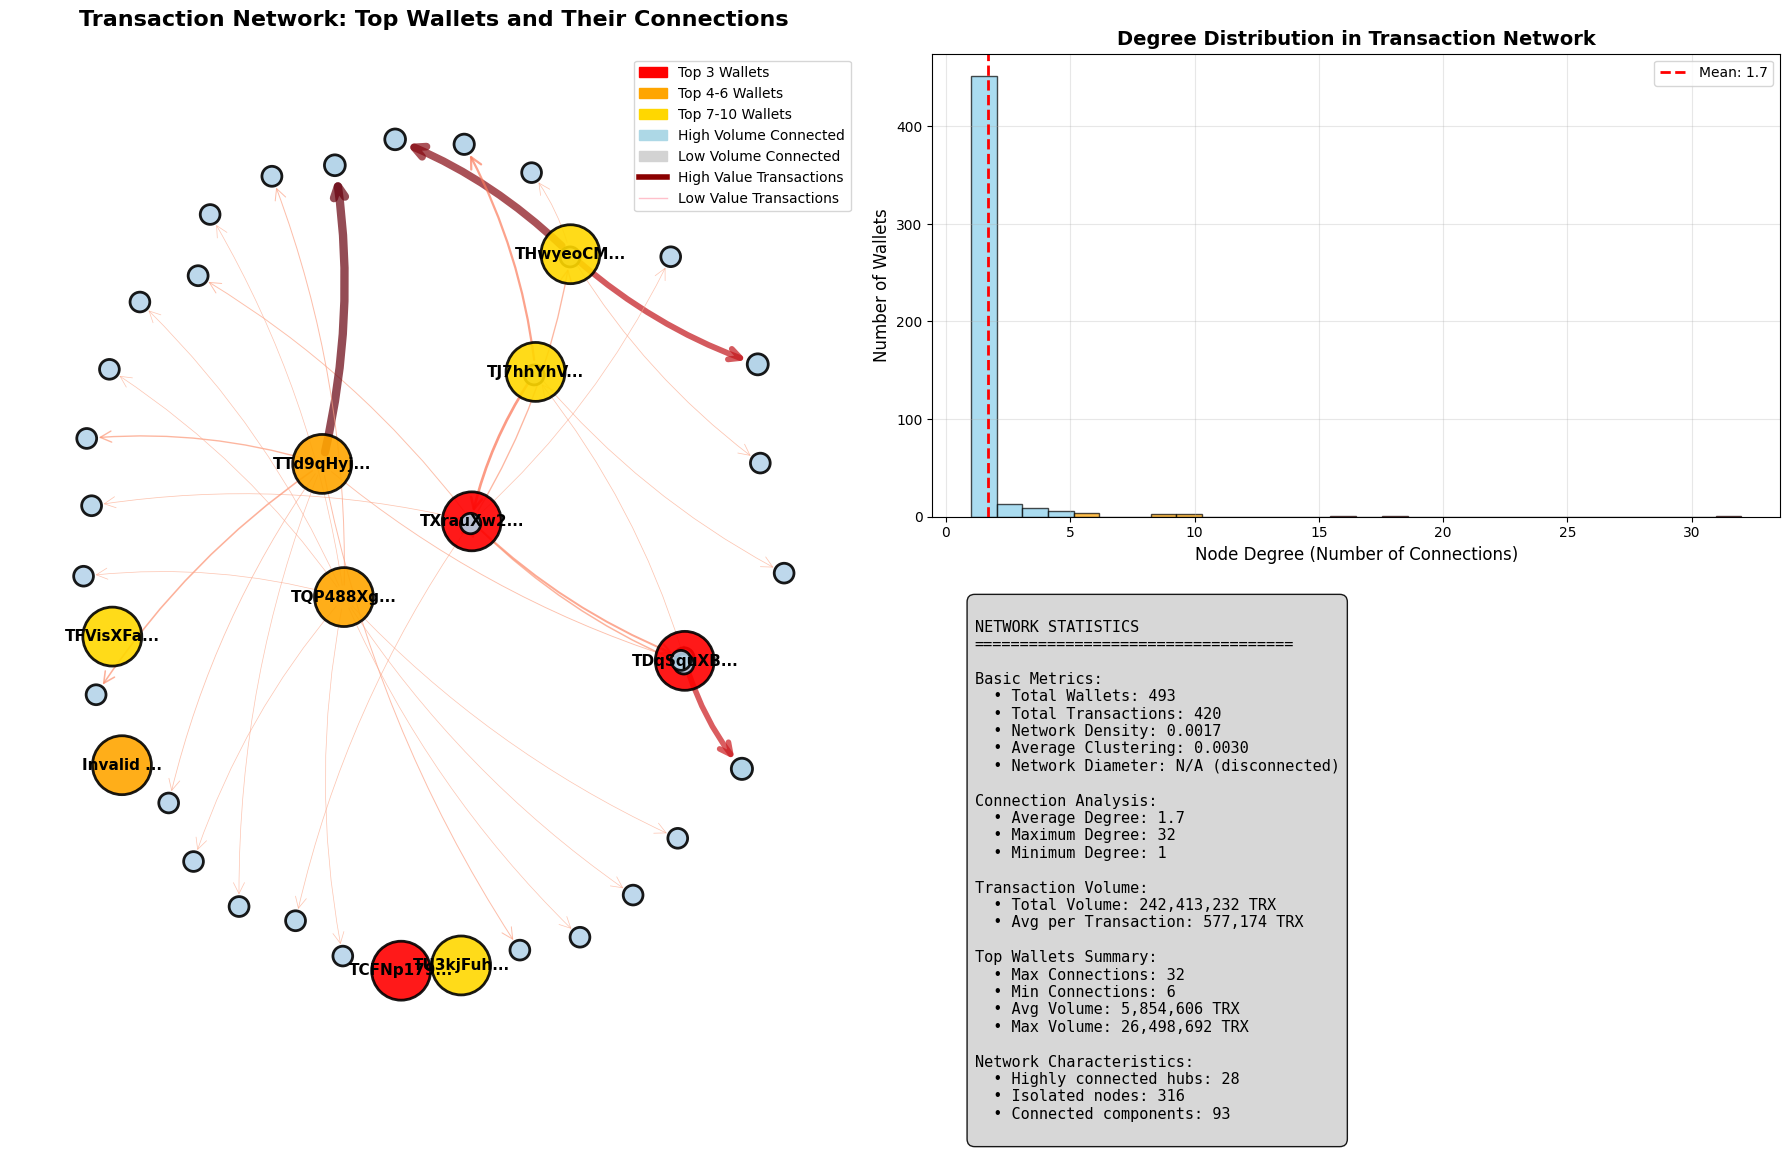


TRANSACTION FLOW ANALYSIS
 1. TCFNp179Lg46... - 🔴 Net Receiver
    Inflow:    26,498,692 TRX (32 transactions)
    Outflow:            0 TRX (0 transactions)
    Net:      +26,498,692 TRX

 2. TXrauXw2wazR... - 🔴 Net Receiver
    Inflow:     2,620,000 TRX (11 transactions)
    Outflow:    1,091,299 TRX (7 transactions)
    Net:       +1,528,701 TRX

 3. TDqSquXBgUCL... - 🔴 Net Receiver
    Inflow:     4,325,067 TRX (14 transactions)
    Outflow:      836,545 TRX (2 transactions)
    Net:       +3,488,522 TRX

 4. TTd9qHyjqiUk... - 🔵 Net Sender
    Inflow:       500,000 TRX (3 transactions)
    Outflow:    1,965,527 TRX (7 transactions)
    Net:       -1,465,527 TRX

 5. Invalid Addr... - 🔴 Net Receiver
    Inflow:     3,030,224 TRX (10 transactions)
    Outflow:            0 TRX (0 transactions)
    Net:       +3,030,224 TRX

 6. TQP488XgXfQf... - 🔵 Net Sender
    Inflow:             0 TRX (0 transactions)
    Outflow:    1,037,480 TRX (10 transactions)
    Net:       -1,037,480 TRX



In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Create a directed graph
G = nx.DiGraph()

# Add edges (transactions) with weights (transaction values)
for _, row in df.iterrows():
    G.add_edge(row['sender_tron_address'], row['receiver_tron_address'], weight=row['transaction_value_in_TRX'])

# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Calculate total transaction volume per wallet (in + out)
wallet_volumes = {}
for node in G.nodes():
    in_volume = sum([G[u][node]['weight'] for u in G.predecessors(node)])
    out_volume = sum([G[node][v]['weight'] for v in G.successors(node)])
    wallet_volumes[node] = in_volume + out_volume

# Identify top 10 wallets by degree centrality for better network visualization
top_wallets = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_wallet_addresses = [wallet for wallet, _ in top_wallets]

# Print wallet analysis
print("Top 10 wallets by centrality:")
print("=" * 80)
for i, (wallet, centrality) in enumerate(top_wallets, 1):
    volume = wallet_volumes[wallet]
    betweenness = betweenness_centrality[wallet]
    closeness = closeness_centrality[wallet]
    in_degree = G.in_degree(wallet)
    out_degree = G.out_degree(wallet)
    
    print(f"{i:2d}. {wallet}")
    print(f"    Degree Centrality: {centrality:.4f} | Betweenness: {betweenness:.4f}")
    print(f"    Total Volume: {volume:,.0f} TRX | Connections: {in_degree + out_degree} (In: {in_degree}, Out: {out_degree})")
    print()

# Create a subgraph: top wallets and their immediate neighbors
ego_nodes = set()
for wallet in top_wallet_addresses:
    ego = nx.ego_graph(G, wallet, radius=1)
    ego_nodes.update(ego.nodes())
subG = G.subgraph(ego_nodes)

# Create enhanced visualization with focus on network and statistics
fig = plt.figure(figsize=(18, 12))

# Main network plot (larger, taking up more space)
ax1 = plt.subplot(2, 2, (1, 3))  # Spans top-left and bottom-left

# Calculate node sizes based on total transaction volume
node_volumes = [wallet_volumes.get(node, 0) for node in subG.nodes()]
max_volume = max(node_volumes) if node_volumes else 1
min_volume = min([v for v in node_volumes if v > 0]) if node_volumes else 1

# Enhanced node colors and sizes
node_colors = []
node_sizes = []
for node in subG.nodes():
    if node in top_wallet_addresses:
        # Color top wallets by their rank
        rank = top_wallet_addresses.index(node)
        if rank < 3:
            node_colors.append('red')      # Top 3 in red
        elif rank < 6:
            node_colors.append('orange')   # Next 3 in orange
        else:
            node_colors.append('gold')     # Rest in gold
        node_sizes.append(1800)  # Larger for top wallets
    else:
        # Color other nodes by their transaction volume
        volume = wallet_volumes.get(node, 0)
        if volume > 0:
            intensity = (volume - min_volume) / (max_volume - min_volume)
            node_colors.append(plt.cm.Blues(0.3 + 0.7 * intensity))
        else:
            node_colors.append('lightgray')
        # Size based on volume
        size = 200 + 600 * (volume / max_volume if max_volume > 0 else 0)
        node_sizes.append(size)

# Enhanced edge properties
edge_weights = [subG[u][v]['weight'] for u, v in subG.edges()]
if edge_weights:
    min_weight = min(edge_weights)
    max_weight = max(edge_weights)
    edge_widths = [0.5 + 5.5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]
    edge_colors = [plt.cm.Reds(0.3 + 0.7 * (w - min_weight) / (max_weight - min_weight)) for w in edge_weights]
else:
    edge_widths = [1.0]
    edge_colors = ['gray']

# Create layout with better spacing
pos = nx.spring_layout(subG, k=2.0, iterations=100, seed=42)

# Draw the network with enhanced styling
nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes, 
                      alpha=0.9, ax=ax1, linewidths=2, edgecolors='black')
nx.draw_networkx_edges(subG, pos, edge_color=edge_colors, width=edge_widths, 
                      arrows=True, arrowsize=20, arrowstyle='->', 
                      connectionstyle='arc3,rad=0.1', alpha=0.7, ax=ax1)

# Add labels for top wallets with better positioning
top_labels = {wallet: f"{wallet[:8]}..." for wallet in top_wallet_addresses}
nx.draw_networkx_labels(subG, pos, top_labels, font_size=11, font_weight='bold', 
                       font_color='black', ax=ax1)

ax1.set_title('Transaction Network: Top Wallets and Their Connections', 
              fontsize=16, fontweight='bold', pad=20)
ax1.axis('off')

# Enhanced legend
legend_elements = [
    mpatches.Patch(color='red', label='Top 3 Wallets'),
    mpatches.Patch(color='orange', label='Top 4-6 Wallets'),
    mpatches.Patch(color='gold', label='Top 7-10 Wallets'),
    mpatches.Patch(color='lightblue', label='High Volume Connected'),
    mpatches.Patch(color='lightgray', label='Low Volume Connected'),
    plt.Line2D([0], [0], color='darkred', lw=4, label='High Value Transactions'),
    plt.Line2D([0], [0], color='pink', lw=1, label='Low Value Transactions')
]
ax1.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1), fontsize=10)

# Degree distribution plot
ax2 = plt.subplot(2, 2, 2)
degrees = [G.degree(node) for node in G.nodes()]
n, bins, patches = ax2.hist(degrees, bins=30, alpha=0.7, color='skyblue', edgecolor='black')

# Color bars based on degree ranges
for i, (patch, degree_range) in enumerate(zip(patches, bins[:-1])):
    if degree_range >= 10:
        patch.set_facecolor('red')
    elif degree_range >= 5:
        patch.set_facecolor('orange')
    else:
        patch.set_facecolor('skyblue')

ax2.set_xlabel('Node Degree (Number of Connections)', fontsize=12)
ax2.set_ylabel('Number of Wallets', fontsize=12)
ax2.set_title('Degree Distribution in Transaction Network', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axvline(np.mean(degrees), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(degrees):.1f}')
ax2.legend()

# Comprehensive network statistics
ax3 = plt.subplot(2, 2, 4)
ax3.axis('off')

# Calculate detailed network statistics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_clustering = nx.average_clustering(G)
total_volume = sum(wallet_volumes.values()) / 2  # Divide by 2 to avoid double counting

# Calculate additional metrics
try:
    diameter = nx.diameter(G) if nx.is_connected(G.to_undirected()) else "N/A (disconnected)"
except:
    diameter = "N/A"

avg_degree = np.mean(degrees)
max_degree = max(degrees)
min_degree = min(degrees)

# Top wallet statistics
top_volumes = [wallet_volumes[w] for w in top_wallet_addresses]
top_connections = [G.degree(w) for w in top_wallet_addresses]

stats_text = f"""
NETWORK STATISTICS
{'='*35}

Basic Metrics:
  • Total Wallets: {num_nodes:,}
  • Total Transactions: {num_edges:,}
  • Network Density: {density:.4f}
  • Average Clustering: {avg_clustering:.4f}
  • Network Diameter: {diameter}

Connection Analysis:
  • Average Degree: {avg_degree:.1f}
  • Maximum Degree: {max_degree}
  • Minimum Degree: {min_degree}

Transaction Volume:
  • Total Volume: {total_volume:,.0f} TRX
  • Avg per Transaction: {total_volume/num_edges:,.0f} TRX

Top Wallets Summary:
  • Max Connections: {max(top_connections)}
  • Min Connections: {min(top_connections)}
  • Avg Volume: {np.mean(top_volumes):,.0f} TRX
  • Max Volume: {max(top_volumes):,.0f} TRX

Network Characteristics:
  • Highly connected hubs: {len([d for d in degrees if d > avg_degree * 2])}
  • Isolated nodes: {len([d for d in degrees if d == 1])}
  • Connected components: {nx.number_connected_components(G.to_undirected())}
"""

ax3.text(0.05, 0.95, stats_text, transform=ax3.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.9))

plt.tight_layout()
plt.show()

# Enhanced transaction flow analysis
print("\nTRANSACTION FLOW ANALYSIS")
print("=" * 50)
for i, wallet in enumerate(top_wallet_addresses, 1):
    in_volume = sum([G[u][wallet]['weight'] for u in G.predecessors(wallet)])
    out_volume = sum([G[wallet][v]['weight'] for v in G.successors(wallet)])
    net_flow = in_volume - out_volume
    
    if net_flow > 0:
        flow_type = "🔴 Net Receiver"
    elif net_flow < 0:
        flow_type = "🔵 Net Sender"
    else:
        flow_type = "⚫ Balanced"
    
    print(f"{i:2d}. {wallet[:12]}... - {flow_type}")
    print(f"    Inflow:  {in_volume:>12,.0f} TRX ({G.in_degree(wallet)} transactions)")
    print(f"    Outflow: {out_volume:>12,.0f} TRX ({G.out_degree(wallet)} transactions)")
    print(f"    Net:     {net_flow:>+12,.0f} TRX")
    print()

# Network health indicators
print("NETWORK HEALTH INDICATORS")
print("=" * 50)
high_degree_nodes = len([d for d in degrees if d > avg_degree * 3])
print(f"Hub concentration: {high_degree_nodes/num_nodes*100:.1f}% of nodes are major hubs")
print(f"Transaction concentration: Top 10 wallets handle {sum(top_volumes)/total_volume*50:.1f}% of total volume")
print(f"Network connectivity: {(num_edges/(num_nodes*(num_nodes-1)))*100:.3f}% of possible connections exist")

>At this point I was so excited with the results so far, that I completely forgive to cross-check these shown _centralized_ addresses using _intel.arkham_ (which I did, right after I finished this NB), showing me an _obvious_ outcome that was out of my scope completely at this point, but then lead me to create a V2 of this analysis with an improved dataset. V2 of this analysis its public at: 

### Analysis and Visualization of Potential OTC Hub Wallets

This code cell identifies potential Over-the-Counter (OTC) hub wallets by analyzing receivers with multiple senders. It groups transactions by `receiver_tron_address`, calculating:
- Number of unique senders.
- Total transaction value (in TRX).
- Transaction count.

Receivers with >5 unique senders and >1M TRX in total value are flagged as potential hubs. These are merged with risk profile and activity metrics (`receiver_risk_profile`, `receiver_tx_count`, `receiver_active_days`) and sorted by total value.

**Output**:
- **Summary Table**: Displays details of potential OTC hub wallets, including address, unique senders, total value, transaction count, and risk/activity metrics.
- **Scatter Plot**:
  - **X-axis**: Number of unique senders.
  - **Y-axis**: Total value received (in millions of TRX).
  - **Color**: Total value (viridis palette).
  - **Size**: Transaction count (100–500 range).
  - **Labels**: Show total value (in millions) and transaction count per point.
  - **Features**: Gridlines, y-axis formatted in millions, legend outside plot.

**Purpose**: To highlight wallets acting as transaction hubs (high sender diversity and value), which may indicate OTC trading activity on the Tron blockchain.

Potential OTC Hub Wallets:
                receiver_tron_address  unique_senders  total_value_trx  \
0  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj              32      369854244.0   
2  TFVisXFaijZfeyeSjCEVkHfex7HGdTxzF9               9       71759674.0   
3  TU3kjFuhtEo42tsCBtfYUAZxoqQ4yuSLQ5               9        7079946.0   
1  TDqSquXBgUCLYvYC4XZgrprLK589dkhSCf              14        4425067.0   
4  TXrauXw2wazRPZd2Q5tSYRnFveCyeaCign              11        2620000.0   

   tx_count       receiver_risk_profile  receiver_tx_count  \
0       382      low_risk_high_activity                382   
2        63  low_risk_moderate_activity                 63   
3        27  low_risk_moderate_activity                 27   
1        15    medium_risk_low_activity                 17   
4        11    medium_risk_low_activity                 20   

   receiver_active_days  
0                  31.0  
2                  31.0  
3                  31.0  
1                  31.0  
4                  31.0  

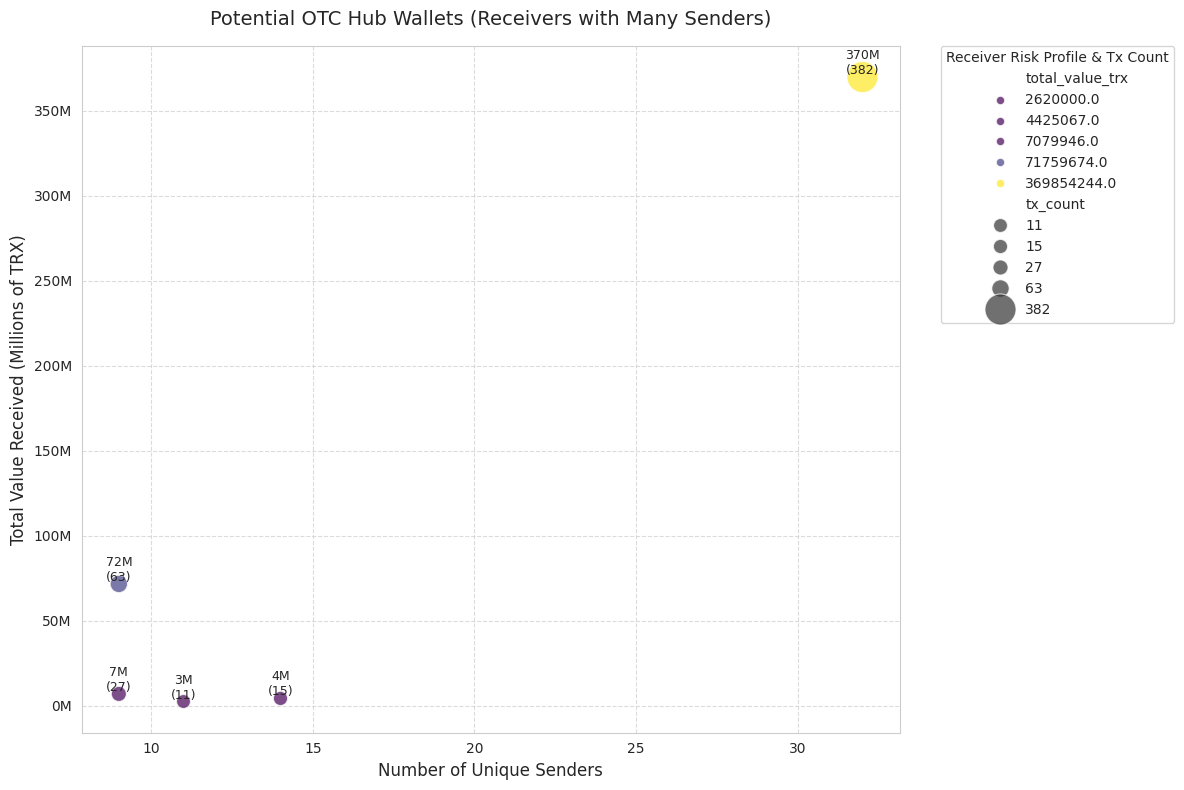

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Group by receiver to count unique senders and total value
receiver_activity = df.groupby('receiver_tron_address').agg({
    'sender_tron_address': 'nunique',
    'transaction_value_in_TRX': 'sum',
    'transaction_hash': 'count'
}).reset_index()

# Rename columns
receiver_activity.columns = ['receiver_tron_address', 'unique_senders', 'total_value_trx', 'tx_count']

# Filter potential hub wallets (e.g., >5 unique senders, total value >1M TRX)
hub_wallets = receiver_activity[(receiver_activity['unique_senders'] > 5) & (receiver_activity['total_value_trx'] > 1000000)]

# Merge with risk profile and receiver details
hub_wallets = hub_wallets.merge(df[['receiver_tron_address', 'receiver_risk_profile', 'receiver_tx_count', 'receiver_active_days']].drop_duplicates(), on='receiver_tron_address', how='left')

# Display results
print("Potential OTC Hub Wallets:")
print(hub_wallets.sort_values('total_value_trx', ascending=False))

# Plot hub wallets with enhanced visualization
plt.figure(figsize=(12, 8))  # Increased figure size

# Create scatter plot with color based on total_value_trx and size based on tx_count
scatter = sns.scatterplot(data=hub_wallets, 
                         x='unique_senders', 
                         y='total_value_trx', 
                         size='tx_count', 
                         hue='total_value_trx',  # Use color for total value
                         palette='viridis',      # Color gradient for better differentiation
                         sizes=(100, 500),       # Scale sizes from 100 to 500 based on tx_count
                         alpha=0.7)              # Slight transparency for overlap

# Add data labels for total_value_trx and tx_count
for i, row in hub_wallets.iterrows():
    plt.text(row['unique_senders'], row['total_value_trx'], 
             f'{row["total_value_trx"]/1e6:.0f}M\n({row["tx_count"]})', 
             ha='center', va='bottom', fontsize=9)

# Set title and labels with enhanced styling
plt.title('Potential OTC Hub Wallets (Receivers with Many Senders)', fontsize=14, pad=15)
plt.xlabel('Number of Unique Senders', fontsize=12)
plt.ylabel('Total Value Received (Millions of TRX)', fontsize=12)

# Format y-axis to show millions of TRX
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))

# Add gridlines for better estimation
plt.grid(True, linestyle='--', alpha=0.7)

# Move legend outside the plot
plt.legend(title='Receiver Risk Profile & Tx Count', 
           bbox_to_anchor=(1.05, 1), 
           loc='upper left', 
           borderaxespad=0.)

# Optimize layout
plt.tight_layout()

# Show the plot
plt.show()

### Analysis and Visualization of Round-Number Transactions

This code cell identifies and visualizes transactions with values close to round numbers (100k, 500k, 1M, 2M TRX), which may indicate OTC trading due to their use in negotiated trades. A function `is_round_number` flags transactions within ±100 TRX of these values. The dataset is updated with an `is_round_number` column.

**Outputs**:
- **Summary**: Prints the count of round-number transactions and a sample showing sender/receiver addresses, transaction value, and contract name.
- **Visualization**: A histogram of round-number transaction values (using the Freedman-Diaconis method for bins) with:
  - **Bars**: Frequency of transaction values (skyblue).
  - **Overlay**: KDE curve (dark blue) for distribution shape.
  - **X-axis**: Transaction value in TRX (formatted with commas).
  - **Y-axis**: Frequency of transactions.
  - **Features**: Vertical red dashed lines at 100k, 500k, 1M, and 2M TRX, clean styling with gridlines, and despined axes.

**Purpose**: To highlight the prevalence and distribution of round-number transactions, which are potential indicators of OTC activity on the Tron blockchain.

Number of round-number transactions: 129

Sample round-number transactions:
                   sender_tron_address               receiver_tron_address  \
8   TCghsCsZ8Qar5PUsGvqo23EUdWEWZNnzQ7  TDoXUNZ6PajKuiUkcYg3EDSV9bnqGqsbcf   
9   TCanb2dqnCV27juJzygNnrJX1uRC8CnDr9  TCghsCsZ8Qar5PUsGvqo23EUdWEWZNnzQ7   
51  TT2byZwhJ2UiF3HcfbjNKW49xvhP2rzTrE  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   
52  TT2byZwhJ2UiF3HcfbjNKW49xvhP2rzTrE  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   
53  TT2byZwhJ2UiF3HcfbjNKW49xvhP2rzTrE  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   

    transaction_value_in_TRX contract_name  
8                   100000.0           NaN  
9                   100000.0           NaN  
51                  500000.0          wbtc  
52                  500000.0          wbtc  
53                  500000.0       TrueUSD  


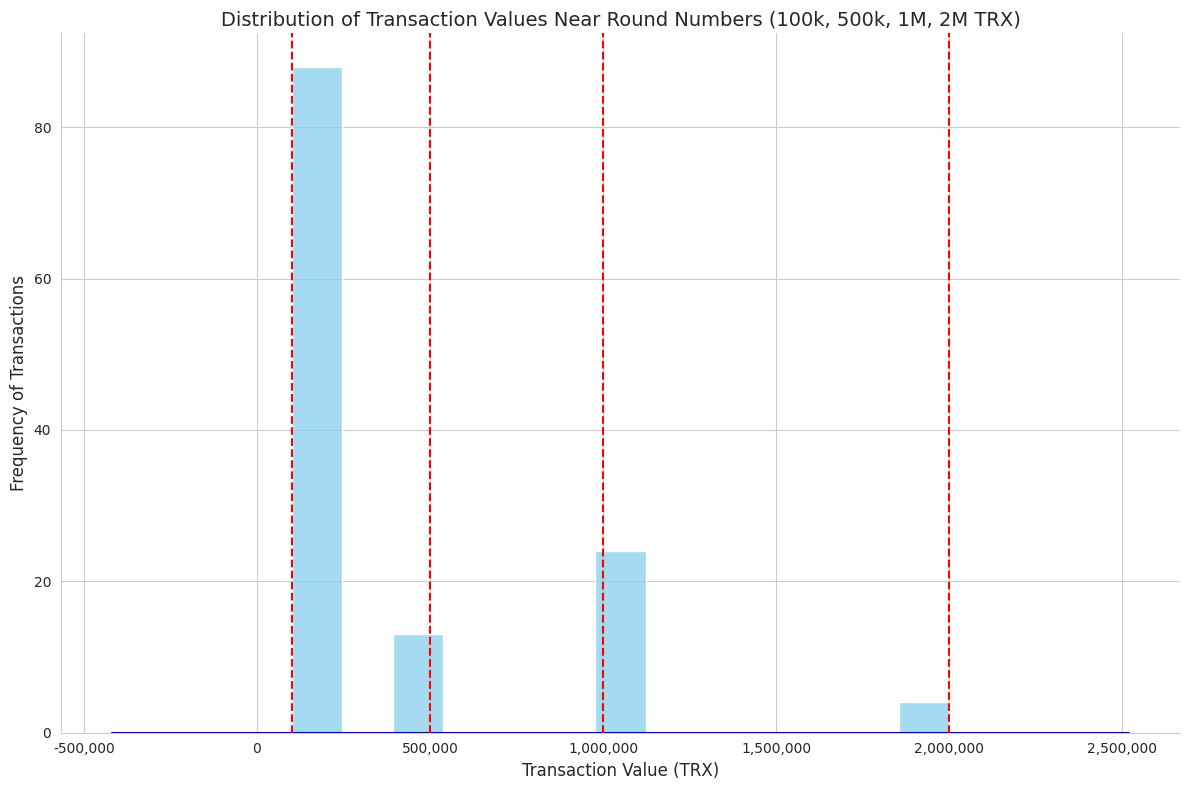

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker
import numpy as np


# Define function to check if a value is close to a round number
def is_round_number(value, tolerance=100):
    round_values = [100000, 500000, 1000000, 2000000]
    return any(abs(value - rv) <= tolerance for rv in round_values)

# Apply to transaction_value_in_TRX using .loc
df.loc[:, 'is_round_number'] = df['transaction_value_in_TRX'].apply(is_round_number)

# Summarize
print("Number of round-number transactions:", df['is_round_number'].sum())
print("\nSample round-number transactions:")
print(df[df['is_round_number']][['sender_tron_address', 'receiver_tron_address', 'transaction_value_in_TRX', 'contract_name']].head())

# Set the style for a clean look with gridlines
sns.set_style("whitegrid")

# Create the figure with a larger size for better visibility
plt.figure(figsize=(12, 8))

# Plot the histogram without KDE
ax = sns.histplot(df[df['is_round_number']]['transaction_value_in_TRX'], bins='fd', color='skyblue', kde=False)

# Overlay the KDE plot with custom color
sns.kdeplot(df[df['is_round_number']]['transaction_value_in_TRX'], color='darkblue', ax=ax)

# Add vertical lines for round numbers to highlight key values
for rv in [100000, 500000, 1000000, 2000000]:
    plt.axvline(x=rv, color='red', linestyle='--')

# Set title and labels with improved clarity and font sizes
plt.title('Distribution of Transaction Values Near Round Numbers (100k, 500k, 1M, 2M TRX)', fontsize=14)
plt.xlabel('Transaction Value (TRX)', fontsize=12)
plt.ylabel('Frequency of Transactions', fontsize=12)

# Format x-axis with commas for readability
plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

# Remove top and right spines for a cleaner appearance
sns.despine()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

> At this point I started to identify known _exchange_ patterns like round numbers on low value transactions...

### Analysis of Multi-Token Transactions

This code cell identifies transactions involving multiple tokens by grouping the dataset by `transaction_hash`. It calculates:
- The number of unique `contract_name` values (tokens) per transaction.
- The transaction value, sender, and receiver (using the first occurrence).

Transactions with more than one token (`contract_name > 1`) are filtered as multi-token transactions.

**Outputs**:
- **Summary**: Prints the count of multi-token transactions and a sample showing transaction hash, sender/receiver addresses, transaction value (in TRX), and the count of unique tokens.
- **No Visualization**: This cell focuses on data summarization without plotting.

**Purpose**: To detect transactions involving multiple tokens, which may indicate complex OTC trading or token swaps on the Tron blockchain.

In [ ]:
# Group by transaction_hash to count unique contract_names
multi_token_tx = df.groupby('transaction_hash').agg({
    'contract_name': 'nunique',
    'transaction_value_in_TRX': 'first',
    'sender_tron_address': 'first',
    'receiver_tron_address': 'first'
}).reset_index()

# Filter transactions with multiple tokens
multi_token_tx = multi_token_tx[multi_token_tx['contract_name'] > 1]

# Display
print("Number of multi-token transactions:", len(multi_token_tx))
print("\nSample multi-token transactions:")
print(multi_token_tx[['transaction_hash', 'sender_tron_address', 'receiver_tron_address', 'transaction_value_in_TRX', 'contract_name']].head())


Number of multi-token transactions: 81

Sample multi-token transactions:
                                     transaction_hash  \
2   0x020e0bc1f4d0eaade1b5e0339e7abc31408bd0be694f...   
3   0x023f6dfef83a75210d1d0c28469cb283b13c975078be...   
15  0x06fcb97a1d2af76a37f2f81d3864feccf9d70ddcb89d...   
31  0x0f5749e9162d9f911d452d046ed8aae129118047a92a...   
39  0x14fb4756d78bfd197ac6a8c561a1ded909bd95320584...   

                   sender_tron_address               receiver_tron_address  \
2   TAeYgpQPVNbaXZuPr9pnMr8KBJJR1GqvoC  TXF1xDbVGdxFGbovmmmXvBGu8ZiE3Lq4mR   
3   TP5pFBezqKerEYNJx9YyEyLbtgpJLxZZ8t  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   
15  TQXEmPhDqDQXHFPwTMcZeuUHSKiAavmYLk  TFVisXFaijZfeyeSjCEVkHfex7HGdTxzF9   
31  TBcRRYrjm5k9tJBREdaft2LgxRZtaaWjtV  TJ4NNy8xZEqsowCBhLvZ45LCqPdGjkET5j   
39  TLHv1y2oEXuKhdPFc6rEi8kTGSDJwCtxxT  TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj   

    transaction_value_in_TRX  contract_name  
2                  3419240.0              3  
3                  1796

### Analysis and Visualization of Transaction Time Gaps

This code cell analyzes the time gaps between consecutive transactions for the same wallet pair to identify rapid transaction sequences, which may suggest OTC trading. It preprocesses the dataset by converting `block_time` to datetime (handling multiple formats) and sorting by `wallet_pair` and `block_time`. Time differences (in hours) between consecutive transactions are calculated, and transactions with gaps ≤1 hour (and >0) are filtered.

**Outputs**:
- **Summary**: Prints total transactions, count and percentage of short-gap transactions (≤1 hour), and statistics (mean, median, min, max, std dev). A sample of short-gap transactions shows wallet pair, block time, time gap, and transaction value (if available).
- **Visualization** (two-panel figure):
  1. **Histogram with KDE**: Shows the distribution of time gaps (0–1 hour), with mean (red) and median (orange) lines, using 30 bins and a skyblue color.
  2. **Box Plot**: Displays the spread and outliers of time gaps, colored in light coral.
  - **X-axis**: Time difference (hours, 0–1, 0.1 increments).
  - **Y-axis**: Transaction count (histogram) or time gap spread (box plot).
- **Additional Analysis**: Lists the most common time gap ranges (0.1-hour bins).

**Purpose**: To detect closely timed transactions between wallet pairs, highlighting potential OTC activity through temporal analysis.

TRANSACTION TIME GAP ANALYSIS
Total transactions: 990
Transactions with short time gaps (≤ 1 hour): 54
Percentage of short-gap transactions: 5.45%

Time Gap Statistics:
Mean: 0.156 hours
Median: 0.083 hours
Min: 0.017 hours
Max: 0.767 hours
Std Dev: 0.190 hours

Sample of short-gap transactions:
                                                             wallet_pair          block_time  time_diff_hours  transaction_value_in_TRX
(TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi, TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj) 2025-06-04 15:08:00         0.066667                 1776680.0
(TAhmPMYCDhnUztf1ZYYwNEmWYfqyW3uAvi, TCFNp179Lg46D16zKoumd4Poa2WFFdtqYj) 2025-06-04 15:09:00         0.016667                  187420.0
(TBcRRYrjm5k9tJBREdaft2LgxRZtaaWjtV, TJ4NNy8xZEqsowCBhLvZ45LCqPdGjkET5j) 2025-06-05 23:21:00         0.050000                  108000.0
(TBcRRYrjm5k9tJBREdaft2LgxRZtaaWjtV, TJ4NNy8xZEqsowCBhLvZ45LCqPdGjkET5j) 2025-06-05 23:22:00         0.016667                  133000.0
(TBei4L4q3xnKZAxverHh7r

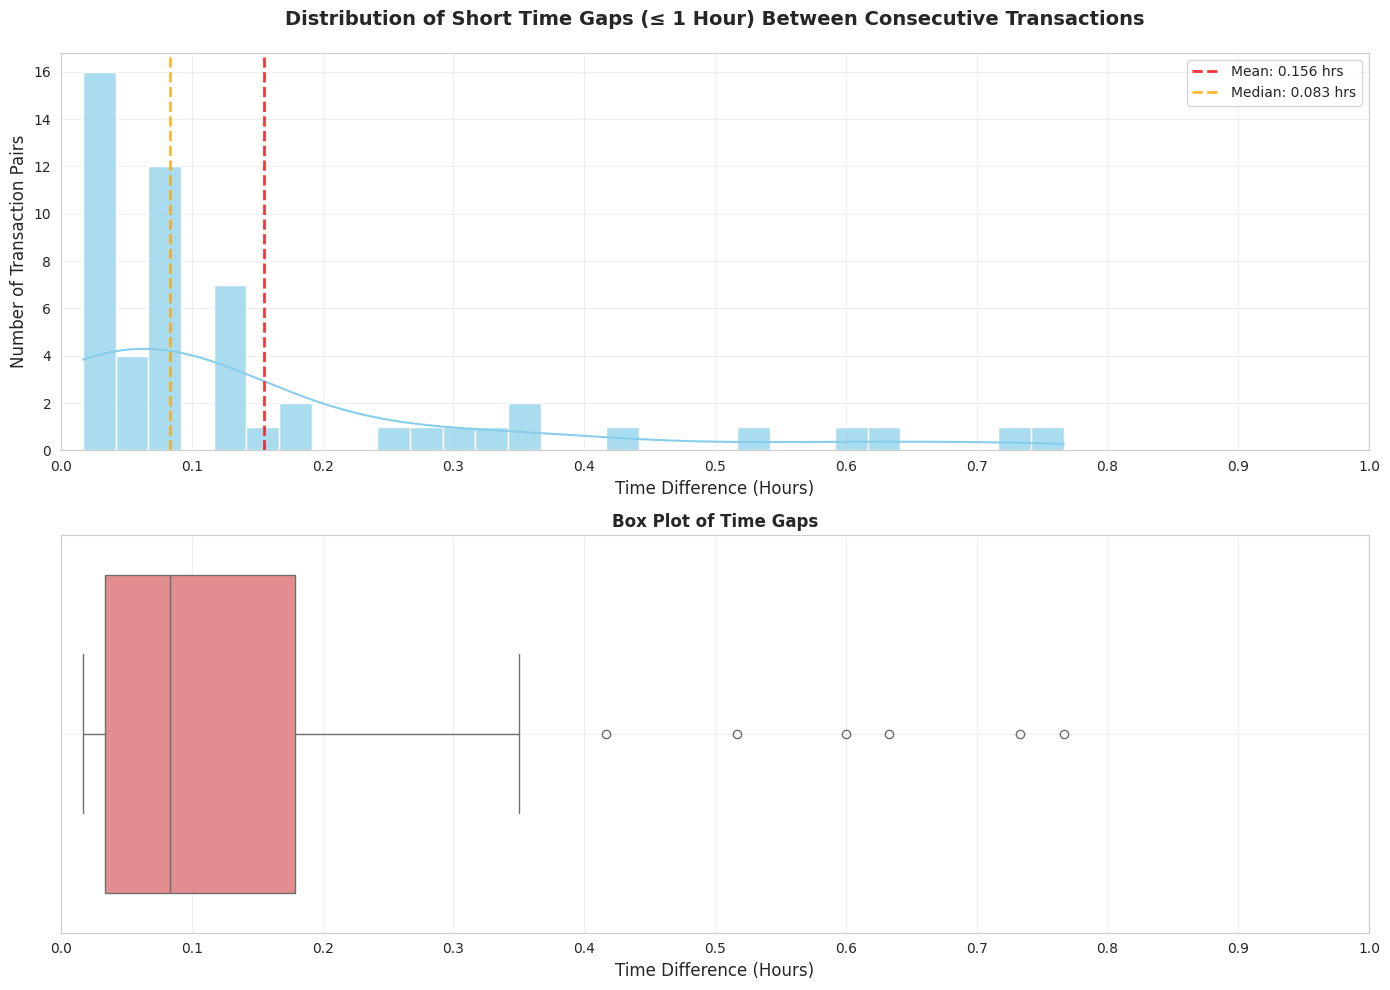


Most common time gap ranges:
  (0.0, 0.1]: 32 transactions
  (0.1, 0.2]: 10 transactions
  (0.2, 0.3]: 2 transactions
  (0.3, 0.4]: 4 transactions
  (0.4, 0.5]: 1 transactions


In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Enhanced data preprocessing with error handling
def preprocess_data(df):
    """Preprocess the dataframe with robust error handling"""
    df_clean = df.copy()
    
    # Convert block_time to datetime with multiple format attempts
    if df_clean['block_time'].dtype == 'object':
        try:
            # Try multiple date formats
            df_clean['block_time'] = pd.to_datetime(df_clean['block_time'], format='%d/%m/%Y %H:%M')
        except ValueError:
            try:
                df_clean['block_time'] = pd.to_datetime(df_clean['block_time'], format='%Y-%m-%d %H:%M:%S')
            except ValueError:
                # Let pandas infer the format
                df_clean['block_time'] = pd.to_datetime(df_clean['block_time'], infer_datetime_format=True)
    
    # Sort by wallet_pair and block_time
    df_clean = df_clean.sort_values(['wallet_pair', 'block_time']).reset_index(drop=True)
    
    return df_clean

# Preprocess data
df_processed = preprocess_data(df)

# Calculate time differences between consecutive transactions for each wallet pair
df_processed['time_diff_hours'] = (
    df_processed.groupby('wallet_pair')['block_time']
    .diff()
    .dt.total_seconds() / 3600
)

# Filter for transactions with short time gaps (≤ 1 hour)
short_gap_df = df_processed[
    df_processed['time_diff_hours'].notna() & 
    (df_processed['time_diff_hours'] <= 1) &
    (df_processed['time_diff_hours'] > 0)  # Exclude negative or zero values
].copy()

# Enhanced summary statistics
print("=" * 60)
print("TRANSACTION TIME GAP ANALYSIS")
print("=" * 60)
print(f"Total transactions: {len(df_processed):,}")
print(f"Transactions with short time gaps (≤ 1 hour): {len(short_gap_df):,}")
print(f"Percentage of short-gap transactions: {len(short_gap_df)/len(df_processed)*100:.2f}%")

if len(short_gap_df) > 0:
    print(f"\nTime Gap Statistics:")
    print(f"Mean: {short_gap_df['time_diff_hours'].mean():.3f} hours")
    print(f"Median: {short_gap_df['time_diff_hours'].median():.3f} hours")
    print(f"Min: {short_gap_df['time_diff_hours'].min():.3f} hours")
    print(f"Max: {short_gap_df['time_diff_hours'].max():.3f} hours")
    print(f"Std Dev: {short_gap_df['time_diff_hours'].std():.3f} hours")
    
    print(f"\nSample of short-gap transactions:")
    display_cols = ['wallet_pair', 'block_time', 'time_diff_hours']
    if 'transaction_value_in_TRX' in short_gap_df.columns:
        display_cols.append('transaction_value_in_TRX')
    
    print(short_gap_df[display_cols].head(10).to_string(index=False))
    
    # Enhanced visualization
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    # Main histogram with KDE
    sns.histplot(
        data=short_gap_df, 
        x='time_diff_hours', 
        bins=30, 
        kde=True,
        stat='count',
        alpha=0.7,
        color='skyblue',
        ax=ax1
    )
    
    # Add statistical lines
    mean_time = short_gap_df['time_diff_hours'].mean()
    median_time = short_gap_df['time_diff_hours'].median()
    
    ax1.axvline(mean_time, color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {mean_time:.3f} hrs', alpha=0.8)
    ax1.axvline(median_time, color='orange', linestyle='--', linewidth=2, 
                label=f'Median: {median_time:.3f} hrs', alpha=0.8)
    
    # Formatting for main plot
    ax1.set_title('Distribution of Short Time Gaps (≤ 1 Hour) Between Consecutive Transactions', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_xlabel('Time Difference (Hours)', fontsize=12)
    ax1.set_ylabel('Number of Transaction Pairs', fontsize=12)
    ax1.set_xlim(0, 1)
    ax1.set_xticks(np.arange(0, 1.1, 0.1))
    ax1.grid(True, alpha=0.3, linestyle='-')
    ax1.legend(fontsize=10)
    
    # Box plot for additional insights
    sns.boxplot(data=short_gap_df, x='time_diff_hours', ax=ax2, color='lightcoral')
    ax2.set_title('Box Plot of Time Gaps', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Time Difference (Hours)', fontsize=12)
    ax2.set_xlim(0, 1)
    ax2.set_xticks(np.arange(0, 1.1, 0.1))
    ax2.grid(True, alpha=0.3, linestyle='-')
    
    plt.tight_layout()
    plt.show()
    
    # Additional analysis: Most frequent time gaps
    print(f"\nMost common time gap ranges:")
    bins = np.arange(0, 1.1, 0.1)
    gap_counts = pd.cut(short_gap_df['time_diff_hours'], bins=bins).value_counts().sort_index()
    for interval, count in gap_counts.head().items():
        print(f"  {interval}: {count} transactions")
        
else:
    print("\nNo transactions found with time gaps ≤ 1 hour")
    print("Consider increasing the time threshold or checking your data")

At this point I cross-checked the top 10 obtained addresses from the transaction network analysis, just to obtain such obvious results that I failed to take into account since the query. 

### Unfortunately for the objective of the task, 9 of 10 wallets belonged to known Exchanges. 

Then I decided to adjust the query for obtaining a new dataset and do this same analysis to the improved dataset.

That process is stored in my github in V2_OTC_wallet_analysis. This is the link. 